<a href="https://colab.research.google.com/github/pulseq/MR-Physics-with-Pulseq/blob/main/tutorials/01_basic_sequences/notebooks/03_from_fid_to_gre1d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# from FID to 1D gradient recalled echo (GRE) sequence
Gradient enables spatial encoding and thus multi-dimensional images can be produced. We can also use gradient for dephasing and recall an echo, aka gradient-recalled echo.   
**exercise:**
1.	This starts from the FID sequence. Now add a trapezoid gradient to the ADC block and its flat-top time is the same as the ADC duration. What do you observe when altering the gradient flat area from zero to higher values?
2.	Set the flat-top area to be Nread/fov. Add a short gradient before the ADC to generate an echo which is centered directly at the ADC block and the echo time is 5 ms.
3. Why the reconstructed spectrum has a frequency shift and a rectangular shape (as below) instead of a sharp peak at frequency = 0 Hz? If you move the pixel from x=0.25 to x=-0.25 (pos=[[0.25, 0., 0]] -> pos=[[-0.25, 0., 0]]), what do you observe? If you move the pixel along y direction (pos=[[-0.25, 0., 0]] -> pos=[[-0.25, 0.25, 0]]), is there any change in the reconstructed spectrum? Why there is no change?
4. (optional) Generate a whole train of gradient echoes after one excitation (hint: use gx = pp.scale_grad(gx, -1) function to reverse the polarity of readout gradients). What is the numerical value of the decay rate of the echo peak? Is this T1, T2, or T2*?


In [1]:
#@title 1D GRE in a pixel phantom - environment setup

!pip show pypulseq || pip install pypulseq &> /dev/null
#!pip install git+https://github.com/imr-framework/pypulseq.git
!wget https://raw.githubusercontent.com/pulseq/MR-Physics-with-Pulseq/main/utils/utils.py &> /dev/null
import math
import warnings
import numpy as np
from matplotlib import pyplot as plt
import pypulseq as mr
# for simulation
!pip show MRzeroCore || pip install MRzeroCore
!wget https://github.com/MRsources/MRzero-Core/raw/main/documentation/playground_mr0/util.py &> /dev/null
!wget https://github.com/MRsources/MRzero-Core/raw/main/documentation/playground_mr0/numerical_brain_cropped.mat &> /dev/null
import utils # several helper functions for simulation and recon
import MRzeroCore as mr0

/usr/local/lib/python3.10/dist-packages/sigpy/config.py:15: UserWarning: Importing cupy failed. For more details, see the error stack below:

Failed to import CuPy.

If you installed CuPy via wheels (cupy-cudaXXX or cupy-rocm-X-X), make sure that the package matches with the version of CUDA or ROCm installed.

On Linux, you may need to set LD_LIBRARY_PATH environment variable depending on how you installed CUDA/ROCm.
On Windows, try setting CUDA_PATH environment variable.

Check the Installation Guide for details:
  https://docs.cupy.dev/en/latest/install.html

Original error:
  ImportError: libcuda.so.1: cannot open shared object file: No such file or directory

  warnings.warn(


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.1/349.1 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.3 MB/s eta 0:00:00


In [2]:
#@title 1D GRE in a pixel phantom - sequence
# %% DEFINE the sequence, FOV and resolution
seq=mr.Sequence()
fov=256e-3
Nread=256
Nphase=1
Nrep=1
TE=5e-3

experiment_id = 'gre1d'
# %% SETUP system
# choose the scanner limits
system = mr.Opts(
    max_grad=28, grad_unit='mT/m', max_slew=150, slew_unit='T/m/s',
    rf_ringdown_time=20e-6, rf_dead_time=100e-6,
    adc_dead_time=20e-6, grad_raster_time=50 * 10e-6)

# Define rf event
# hard pulse for excitation
rf_ex = mr.make_block_pulse(flip_angle=90*np.pi/180, duration=1e-3, phase_offset=0*np.pi/180, delay=0e-3, system=system)

# Define ADC event
adc = mr.make_adc(num_samples=Nread, duration=5.12e-3, phase_offset=0*np.pi/180, delay=0e-3, system=system)
deltak = 1/fov
gx = mr.make_trapezoid(channel='x', flat_area=Nread*deltak, flat_time=adc.dwell*adc.num_samples, system=system)
adc.delay = gx.rise_time
#gx_pre = mr.make_trapezoid(channel='x', area=-gx.area/2, duration=1e-3, system=system)
#delayTE = np.ceil((TE-mr.calc_duration(gx_pre) - rf_ex.shape_dur/2-rf_ex.ringdown_time-adc.delay-adc.dwell*adc.num_samples/2)/seq.grad_raster_time)*seq.grad_raster_time
# ======
# CONSTRUCT SEQUENCE
# ======
seq.add_block(rf_ex)
#seq.add_block(mr.make_delay(delayTE))
#seq.add_block(gx_pre)
for i in range(Nrep):
  #seq.add_block(adc)
  seq.add_block(gx, adc)
  #gx = mr.scale_grad(gx, -1)

(ok, error_report) = seq.check_timing()  # Check whether the timing of the sequence is correct
if ok:
    print("Timing check passed successfully")
else:
    print("Timing check failed. Error listing follows:")
    [print(e) for e in error_report]

# Prepare the sequence output for the scanner
seq.set_definition('Name', 'gre1d')
seq.write('03_fid2gre1d.seq')

Timing check passed successfully


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


CustomVoxelPhantom
Voxel shape: box
Voxel size: tensor([0.1000, 0.1000, 0.1000])


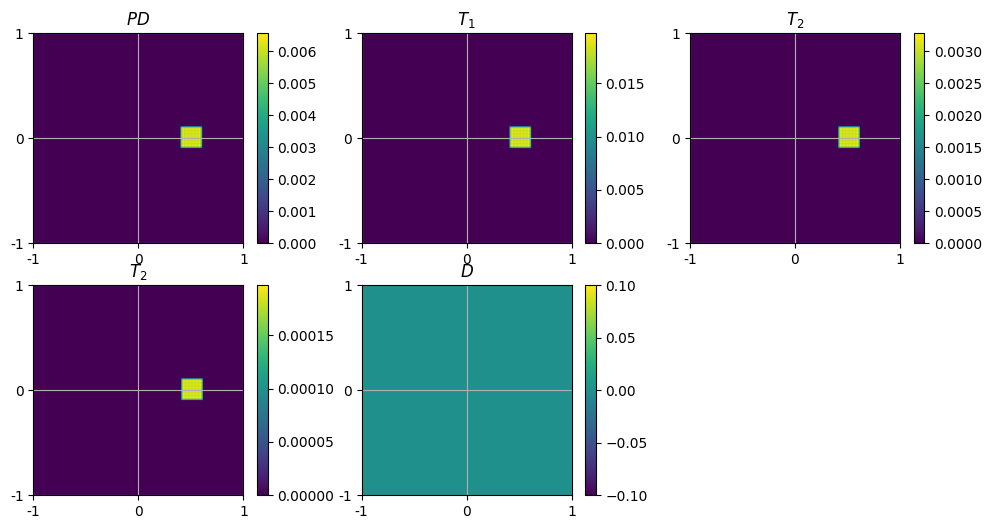

Some sections were ignored: ['SIGNATURE']


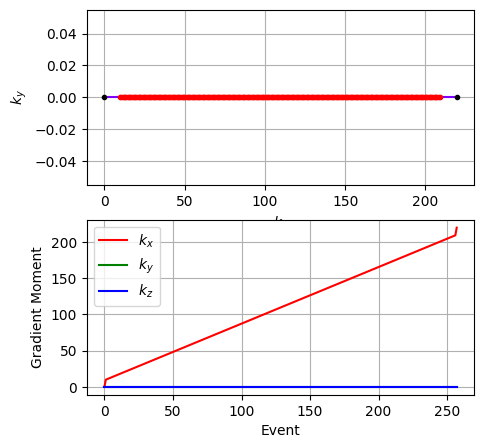

Calculating repetition 1 / 1 - done


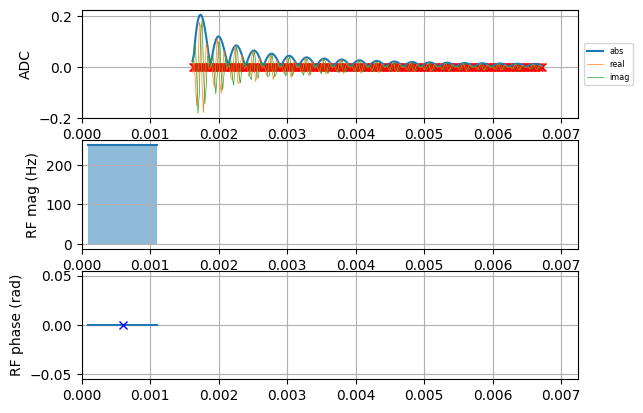

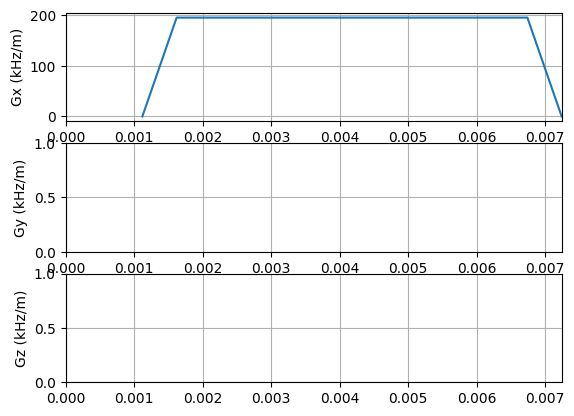

In [3]:
#@title 1D GRE in a pixel phantom - simulation
dB0 = 0
# %% S4: SETUP SPIN SYSTEM/object on which we can run the MR sequence external.seq from above
# set phantom  manually to a pixel phantom. Coordinate system is [-0.5, 0.5]^3
obj_p = mr0.CustomVoxelPhantom(
        pos=[[0.25, 0., 0]],
        PD=[1.0],
        T1=[3.0],
        T2=[0.5],
        T2dash=[30e-3],
        D=[0.0],
        B0=0,
        voxel_size=0.1,
        voxel_shape="box"
    )
# Manipulate loaded data
obj_p.B0+=dB0
obj_p.D*=0
obj_p.plot()
# Convert Phantom into simulation data
obj_p=obj_p.build()

# %% SIMULATE  the external.seq file and add acquired signal to ADC plot
# Read in the sequence
seq0 = mr0.Sequence.from_seq_file("03_fid2gre1d.seq")
seq0.plot_kspace_trajectory()
# Simulate the sequence
graph=mr0.compute_graph(seq0, obj_p, 200, 1e-3)
signal=mr0.execute_graph(graph, seq0, obj_p)
# PLOT sequence with signal in the ADC subplot
plt.close(11);plt.close(12)
sp_adc, t_adc = mr0.util.pulseq_plot(seq,signal=signal.numpy())

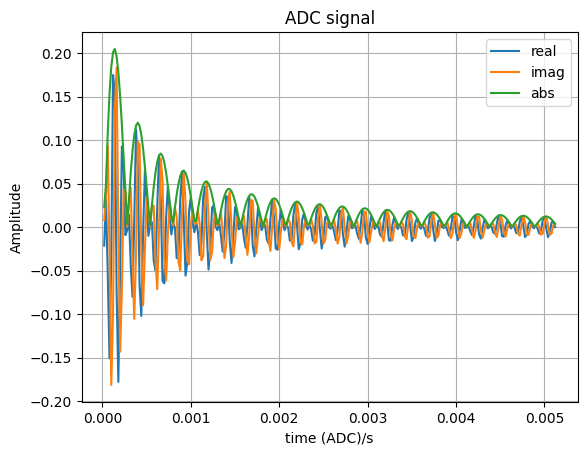

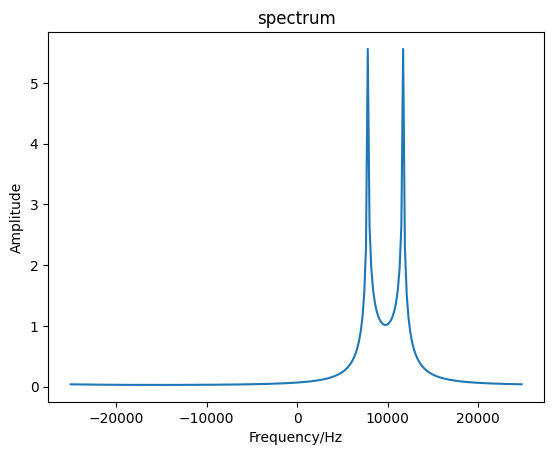

In [4]:
#@title 1D GRE in a pixel phantom - reconstruction
# 1D FFT
def fft_1d(x):
    return np.fft.fftshift(np.fft.fftn(np.fft.ifftshift(x)))

# detailed ADC plot for one repetition
if Nrep==1:
  plt.figure()
  plt.title('ADC signal')
  # time axis
  time_axis=np.linspace(1, Nread, Nread)*adc.dwell ;
  plt.plot(time_axis, np.real(signal), label='real')
  plt.plot(time_axis, np.imag(signal), label='imag')
  plt.plot(time_axis, np.abs(signal), label='abs')
  plt.grid()
  plt.legend(loc="upper right")
  plt.xlabel('time (ADC)/s')
  plt.ylabel('Amplitude')

  # FFT reconstruction
  spectrum = fft_1d(signal)

  # frequency axis
  freq_axis = np.linspace(-Nread/2, Nread/2-1, Nread)/(adc.dwell*adc.num_samples) ; # remain to be checked whether -1 should be included or not

  plt.figure()
  plt.title('spectrum')
  plt.plot(freq_axis, np.abs(spectrum))
  plt.xlabel('Frequency/Hz')
  plt.ylabel('Amplitude')